In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_csv("datos_limpios.csv")

In [30]:
X = df.drop(columns=['riesgo_hipertension', 'FOLIO_I'], errors='ignore')  
y = df['riesgo_hipertension']

In [31]:
X = pd.get_dummies(X, drop_first=True)

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [34]:
modelo = RandomForestClassifier(min_samples_leaf=1,min_samples_split=2,max_depth=15, random_state=42)
modelo.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, random_state=42)

In [35]:
y_pred = modelo.predict(X_test)

In [36]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

  Con riesgo       1.00      0.95      0.97       477
  Sin riesgo       0.82      0.98      0.89       121

    accuracy                           0.95       598
   macro avg       0.91      0.96      0.93       598
weighted avg       0.96      0.95      0.95       598



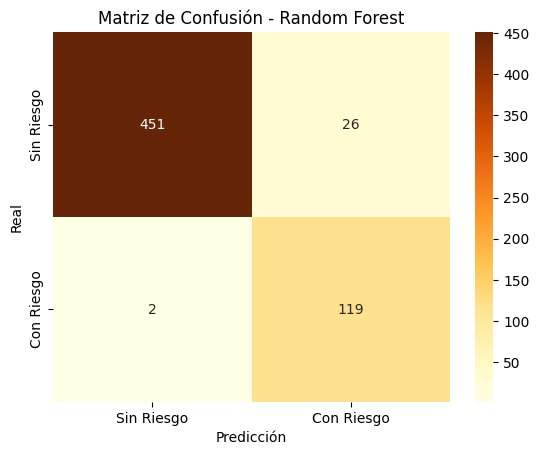

In [38]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=["Sin Riesgo", "Con Riesgo"], yticklabels=["Sin Riesgo", "Con Riesgo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [11]:
import joblib

joblib.dump(modelo, 'modelo_riesgo_rf.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [12]:
# Reemplazar texto por valores numéricos
y_train_bin = y_train.replace({'Con riesgo': 1, 'Sin riesgo': 0})
y_test_bin = y_test.replace({'Con riesgo': 1, 'Sin riesgo': 0})


C:\Users\sider\AppData\Local\Temp\ipykernel_49060\1310143902.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train_bin = y_train.replace({'Con riesgo': 1, 'Sin riesgo': 0})
C:\Users\sider\AppData\Local\Temp\ipykernel_49060\1310143902.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_bin = y_test.replace({'Con riesgo': 1, 'Sin riesgo': 0})


In [13]:
# modelo XGBClassifier ajustado con GridSearchCV

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# peso para balancear clases
peso_clases = y_train_bin.value_counts()[0] / y_train_bin.value_counts()[1]

modelo_base = XGBClassifier(
    random_state=42,
    scale_pos_weight=peso_clases,
    use_label_encoder=False,
    eval_metric='logloss'
)

parametros = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=modelo_base,
    param_grid=parametros,
    scoring='f1_macro',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# aquí se entrena buscando los mejores hiperparámetros
grid.fit(X_train, y_train_bin)

mejor_modelo = grid.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\sider\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:34:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [14]:
y_probs_xgb = mejor_modelo.predict_proba(X_test)[:, 1]
umbral = 0.4
y_pred_xgb = (y_probs_xgb >= umbral).astype(int)

y_pred_labels = ['Con riesgo' if val == 1 else 'Sin riesgo' for val in y_pred_xgb]
y_test_labels = y_test.tolist()

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

  Con riesgo       0.99      0.95      0.97       477
  Sin riesgo       0.82      0.98      0.89       121

    accuracy                           0.95       598
   macro avg       0.91      0.96      0.93       598
weighted avg       0.96      0.95      0.95       598



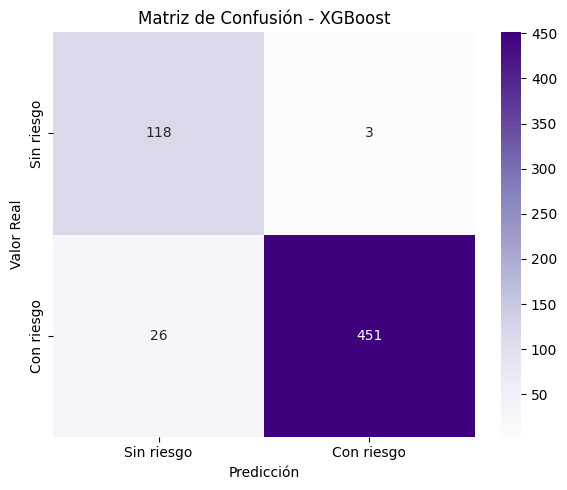

In [15]:
matriz = confusion_matrix(y_test_labels, y_pred_labels, labels=['Sin riesgo', 'Con riesgo'])

plt.figure(figsize=(6, 5))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Sin riesgo', 'Con riesgo'],
            yticklabels=['Sin riesgo', 'Con riesgo'])

plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()


In [23]:
modelo_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# entrenamiento
modelo_lr.fit(X_train, y_train_bin)

# predicción 
y_probs_lr = modelo_lr.predict_proba(X_test)[:, 1]

# umbral
umbral = 0.5
y_pred_lr = (y_probs_lr >= umbral).astype(int)

# etiquetas
y_pred_labels_lr = ['Con riesgo' if val == 1 else 'Sin riesgo' for val in y_pred_lr]

# resultados
print("Reporte de clasificación - regresión")
print(classification_report(y_test_labels, y_pred_labels_lr))

Reporte de clasificación - regresión
              precision    recall  f1-score   support

  Con riesgo       0.95      0.81      0.87       477
  Sin riesgo       0.52      0.82      0.64       121

    accuracy                           0.81       598
   macro avg       0.74      0.81      0.76       598
weighted avg       0.86      0.81      0.83       598



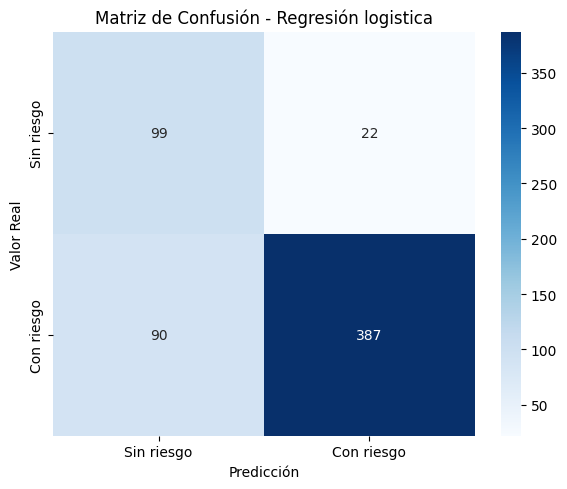

In [24]:
matriz_lr = confusion_matrix(y_test_labels, y_pred_labels_lr, labels=['Sin riesgo', 'Con riesgo'])

plt.figure(figsize=(6, 5))
sns.heatmap(matriz_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sin riesgo', 'Con riesgo'],
            yticklabels=['Sin riesgo', 'Con riesgo'])

plt.title('Matriz de Confusión - Regresión logistica')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

In [18]:
from sklearn.naive_bayes import GaussianNB

In [19]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from sklearn.metrics import f1_score

Distribución original: Counter({1: 1907, 0: 481})
Distribución con SMOTE: Counter({1: 1907, 0: 1907})
Mejor umbral: 0.1, F1-score: 0.737

Reporte de clasificación - Naive Bayes con SMOTE
              precision    recall  f1-score   support

  Con riesgo       0.90      0.63      0.74       477
  Sin riesgo       0.33      0.71      0.45       121

    accuracy                           0.64       598
   macro avg       0.61      0.67      0.59       598
weighted avg       0.78      0.64      0.68       598



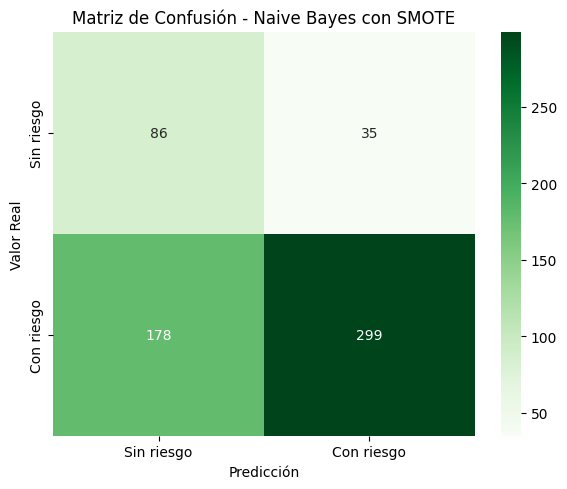

In [21]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter
modelo_nb = GaussianNB()

# aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_bin)

print("Distribución original:", Counter(y_train_bin))
print("Distribución con SMOTE:", Counter(y_train_smote))

# entrenar modelo con datos balanceados
modelo_nb_smote = GaussianNB()
modelo_nb_smote.fit(X_train_smote, y_train_smote)

# predicción
y_probs_smote = modelo_nb_smote.predict_proba(X_test)[:, 1]

# encontrar mejor umbral
umbrales = np.arange(0.1, 0.9, 0.05)
mejor_f1 = 0
mejor_umbral = 0.5

for umbral in umbrales:
    y_pred = (y_probs_smote >= umbral).astype(int)
    y_pred_labels = ['Con riesgo' if val == 1 else 'Sin riesgo' for val in y_pred]
    f1 = f1_score(y_test_labels, y_pred_labels, pos_label='Con riesgo')
    
    if f1 > mejor_f1:
        mejor_f1 = f1
        mejor_umbral = umbral

print(f"Mejor umbral: {mejor_umbral}, F1-score: {mejor_f1:.3f}")

# predicción final con mejor umbral
y_pred_smote = (y_probs_smote >= mejor_umbral).astype(int)
y_pred_labels_smote = ['Con riesgo' if val == 1 else 'Sin riesgo' for val in y_pred_smote]

# resultados
print("\nReporte de clasificación - Naive Bayes con SMOTE")
print(classification_report(y_test_labels, y_pred_labels_smote))

# matriz de confusión
matriz_smote = confusion_matrix(y_test_labels, y_pred_labels_smote, labels=['Sin riesgo', 'Con riesgo'])

plt.figure(figsize=(6, 5))
sns.heatmap(matriz_smote, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Sin riesgo', 'Con riesgo'],
            yticklabels=['Sin riesgo', 'Con riesgo'])
plt.title('Matriz de Confusión - Naive Bayes con SMOTE')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()